In [1]:
import numpy as np
from hamiltonians import *
from helpers import *
import time

In [2]:
def get_submatrix(H, term):
    nbits = H.nbits
    nops = 2**nbits
    h_mat = np.zeros((nops,nops), dtype=complex)
    hm = H.hm_list[term]
    if nbits == 1:
        for i in range(len(hm[0])):
            h_mat += hm[1][i] * sigma_matrices[hm[0][i]]
    else:
        active = [H.map[hm[2][i]] for i in range(len(hm[2]))]
        nactive = len(active)
        nterms = len(hm[0])
        for i in range(nterms):
            full_pauli_str = [0] * nbits
            partial_pauli_str = int_to_base(hm[0][i],4,nactive)
            for j in range(nactive):
                full_pauli_str[active[j]] = partial_pauli_str[j]
            # reverse the string to be consistend with Qiskit's qubit ordering
            full_pauli_str = full_pauli_str[::-1]
            # The matrix for the term is a tensor product of the corresponding Pauli matrices
            term_matrix = sigma_matrices[full_pauli_str[0]]
            for j in range(1,nbits):
                term_matrix = np.kron(term_matrix, sigma_matrices[full_pauli_str[j]])
            # Scale by the coefficient of the term
            term_matrix *= hm[1][i]

            # Add the term to the final matrix
            h_mat += term_matrix
    return h_mat

In [11]:
TOLERANCE = 1e-8

def exp_mat_psi(mat, psi, truncate:int=-1):
    chi = psi.copy()
    phi = psi.copy()
    i = 1
    while (truncate < 0 and np.linalg.norm(chi) > TOLERANCE) or (truncate >= 0 and i <= truncate) :
        chi = 1/i * (mat @ chi)
        phi += chi
        i += 1
    return phi

def get_delta0(H: Hamiltonian, term, psi0, truncate:int=-1):
    d0 = exp_mat_psi(get_submatrix(H, term) * db, psi0, truncate)
        
    c = np.linalg.norm(d0)
    d0 /= c
    d0 -= psi0
    d0 /= db
    return d0

def update_alist(H: Hamiltonian, term, psi0, truncate:int=-1):  
    hm = H.hm_list[term]
    h_mat = get_submatrix(H, term)
    nbits = H.nbits
    active = hm[2]
    nactive = len(hm[2])
    nops = 4**nactive
    
    S = np.eye(nops, dtype=complex)
    b = np.zeros(nops, dtype=complex)
    for i in range(nops):
        for j in range(i):
            p_, c_ = pauli_string_prod(i, j, nactive)
            partial_pstring = int_to_base(p_, 4, nactive)
            full_pstring = [0] * nbits
            for k in range(nactive):
                full_pstring[active[k]] = partial_pstring[k]
            p_mat = sigma_matrices[full_pstring[0]]
            for k in range(1,nbits):
                p_mat = np.kron(sigma_matrices[full_pstring[k]], p_mat)
            
            S[i,j] = np.vdot(psi0, p_mat@psi0) * c_
            S[j,i] = S[i,j].conjugate()
        S[i,i] = 1.0
    
    psi_prime = exp_mat_psi(get_submatrix(H, term)*db, psi0, truncate=truncate)
    c = np.linalg.norm(psi_prime)
    for i in range(nops):
        partial_pstring = int_to_base(i, 4, nactive)
        full_pstring = [0] * nbits
        for k in range(nactive):
            full_pstring[active[k]] = partial_pstring[k]
        p_mat = sigma_matrices[full_pstring[0]]
        for k in range(1,nbits):
            p_mat = np.kron(sigma_matrices[full_pstring[k]], p_mat)
        b[i] = 2/(db*c) * np.imag( np.vdot(psi0, p_mat @ psi_prime) )
    
    a = np.linalg.lstsq( 2*np.real(S), -b, rcond=-1 )[0]
    
    return a, S, b

def qite_step(H:Hamiltonian, psi0, truncate:int=-1, trotter_update:bool=False):
    alist = []
    slist = []
    blist = []
    psi = psi0.copy()
    nbits = H.nbits
    for term in range(H.num_terms):
        a,S,b = update_alist(H, term, psi, truncate)
        alist.append(a)
        slist.append(S)
        blist.append(b)
        
        #update the state
        hm = H.hm_list[term]
        active = hm[2]
        nactive = len(active)
        nops = 4**nactive
        A = np.zeros((2**nbits, 2**nbits), dtype=complex)
        for i in range(nops):
            partial_pstring = int_to_base(i, 4, nactive)
            full_pstring = [0] * nbits
            for k in range(nactive):
                full_pstring[active[k]] = partial_pstring[k]
            p_mat = sigma_matrices[full_pstring[0]]
            for k in range(1,nbits):
                p_mat = np.kron(sigma_matrices[full_pstring[k]], p_mat)
            A += a[i] * p_mat
            if trotter_update:
                psi = exp_mat_psi(-1j*a[i]*db*p_mat, psi)
        if not trotter_update:
            psi = exp_mat_psi(-1j*A*db, psi)
                
    
    return alist, slist, blist, psi

def qite(H:Hamiltonian, psi0, N, logging:bool=True, truncate:int=-1, trotter_update: bool=False):
    alist = []
    slist = []
    blist = []
    svs = np.zeros((N+1,psi0.shape[0]), dtype=complex)
    svs[0,:] = psi0
    for i in range(1,N+1):
        if logging: print('Iteration {}...'.format(i),end=' ', flush=True)
        t0 = time.time()
        n_a, n_s, n_b, phi = qite_step(H, svs[i-1], truncate, trotter_update)
        alist += n_a
        slist += n_s
        blist += n_b
        svs[i,:] = phi
        t1 = time.time()
        duration = t1-t0
        if logging: print('Done -- Iteration time = {:0.2f} {}'.format(duration if duration < 60 else duration/60, 'seconds' if duration < 60 else 'minutes'))
    return alist, slist, blist, svs

In [4]:
import matplotlib.pyplot as plt
def plot_qite(H: Hamiltonian, psi0, svs, fig_title='', show=True, save=False, file_name=None):
    f = plt.figure(figsize=(10,4))
    axs = [f.add_subplot(121), f.add_subplot(122)]
    t = np.arange(0,N+1,1)*db
    re = np.real(svs)
    im = np.imag(svs)

    theory = np.zeros( (N+1,2), dtype=complex )
    for i in range(N+1):
        v = exp_mat_psi(H.get_matrix() * i*db, psi0)
        theory[i,:] = v/np.linalg.norm(v)

    axs[0].plot(t,re[:,0],'ro-', label='|0>')
    axs[0].plot(t,re[:,1],'bo-', label='|1>')

    axs[0].plot(t, np.real(theory[:,0]), 'r--', label='theory |0>' )
    axs[0].plot(t, np.real(theory[:,1]), 'b--', label='theory |0>' )

    axs[1].plot(t,im[:,0],'ro-', label='|0>')
    axs[1].plot(t,im[:,1],'bo-', label='|1>')

    axs[1].plot(t, np.imag(theory[:,0]), 'r--', label='theory |0>' )
    axs[1].plot(t, np.imag(theory[:,1]), 'b--', label='theory |0>' )

    axs[0].set_ylim(-1.5,1.5)
    axs[1].set_ylim(-1.5,1.5)

    axs[0].title.set_text('Real Part')
    axs[1].title.set_text('Imaginary Part')


    axs[0].legend(loc='best')

    axs[0].grid()
    axs[1].grid()

    f.suptitle('Amplitudes during evolution\n'+fig_title, fontsize=16)
    f.tight_layout()
    f.set_facecolor('white')
    
    if show: plt.show()
    
    if save: f.savefig(file_name+'.png')
        
    plt.close()

In [19]:
db = 0.1
delta = 0.0
N = 50
D = 0
# nbits = H.nbits

truncate_exp = -1

psi0 = np.array([1,0,0,0], dtype=complex)
# psi0 = np.array([1,1], dtype=complex)*np.sqrt(0.5)

In [29]:
def plot_comp(H: Hamiltonian, psi0, svs_full, svs_lin, ax_titles, fig_title='', show=True, save=False, file_name=None):
    f, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10,8))
    
    t = np.arange(0,N+1,1)*db
    re = np.real(svs_full)
    im = np.imag(svs_full)

    theory = np.zeros( (N+1,svs_full.shape[1]), dtype=complex )
    for i in range(N+1):
        v = exp_mat_psi(H.get_matrix() * i*db, psi0)
        theory[i,:] = v/np.linalg.norm(v)
        
    color = 'rbgy'

    for i in range(svs_full.shape[1]):
        axs[0,0].plot(t, re[:,i], color[i]+'o-', label='|{}>'.format(i))
        axs[0,1].plot(t, im[:,i], color[i]+'o-', label='|{}>'.format(i))
        
        axs[0,0].plot(t, np.real(theory[:,i]), color[i]+'--', label='Theory |{}>'.format(i))
        axs[0,1].plot(t, np.imag(theory[:,i]), color[i]+'--', label='Theory |{}>'.format(i))
#     axs[0,0].plot(t,re[:,0],'ro-', label='|0>')
#     axs[0,0].plot(t,re[:,1],'bo-', label='|1>')

#     axs[0,0].plot(t, np.real(theory[:,0]), 'r--', label='theory |0>' )
#     axs[0,0].plot(t, np.real(theory[:,1]), 'b--', label='theory |0>' )

#     axs[0,1].plot(t,im[:,0],'ro-', label='|0>')
#     axs[0,1].plot(t,im[:,1],'bo-', label='|1>')

#     axs[0,1].plot(t, np.imag(theory[:,0]), 'r--', label='theory |0>' )
#     axs[0,1].plot(t, np.imag(theory[:,1]), 'b--', label='theory |0>' )

    axs[0,0].set_ylim(-1.5,1.5)
    axs[0,1].set_ylim(-1.5,1.5)

    axs[0,0].title.set_text(ax_titles[0][0])
    axs[0,1].title.set_text(ax_titles[0][1])
    
    re = np.real(svs_lin)
    im = np.imag(svs_lin)
    
    for i in range(svs_full.shape[1]):
        axs[1,0].plot(t, re[:,i], color[i]+'o-', label='|{}>'.format(i))
        axs[1,1].plot(t, im[:,i], color[i]+'o-', label='|{}>'.format(i))
        
        axs[1,0].plot(t, np.real(theory[:,i]), color[i]+'--', label='Theory |{}>'.format(i))
        axs[1,1].plot(t, np.imag(theory[:,i]), color[i]+'--', label='Theory |{}>'.format(i))
    
#     axs[1,0].plot(t,re[:,0],'ro-', label='|0>')
#     axs[1,0].plot(t,re[:,1],'bo-', label='|1>')

#     axs[1,0].plot(t, np.real(theory[:,0]), 'r--', label='theory |0>' )
#     axs[1,0].plot(t, np.real(theory[:,1]), 'b--', label='theory |0>' )

#     axs[1,1].plot(t,im[:,0],'ro-', label='|0>')
#     axs[1,1].plot(t,im[:,1],'bo-', label='|1>')

#     axs[1,1].plot(t, np.imag(theory[:,0]), 'r--', label='theory |0>' )
#     axs[1,1].plot(t, np.imag(theory[:,1]), 'b--', label='theory |0>' )

#     axs[1,0].set_ylim(-1.5,1.5)
#     axs[1,1].set_ylim(-1.5,1.5)

    axs[1,0].title.set_text(ax_titles[1][0])
    axs[1,1].title.set_text(ax_titles[1][1])


    axs[0,0].legend(loc='best')

    axs[0,0].grid()
    axs[0,1].grid()
    axs[1,0].grid()
    axs[1,1].grid()
    
    for ax in axs.flat:
        ax.label_outer()

    f.suptitle('Amplitudes during evolution\n'+fig_title, fontsize=16)
    f.tight_layout()
    f.set_facecolor('white')
    
    if show: plt.show()
    
    if save: f.savefig(file_name+'.png')
        
    plt.close()

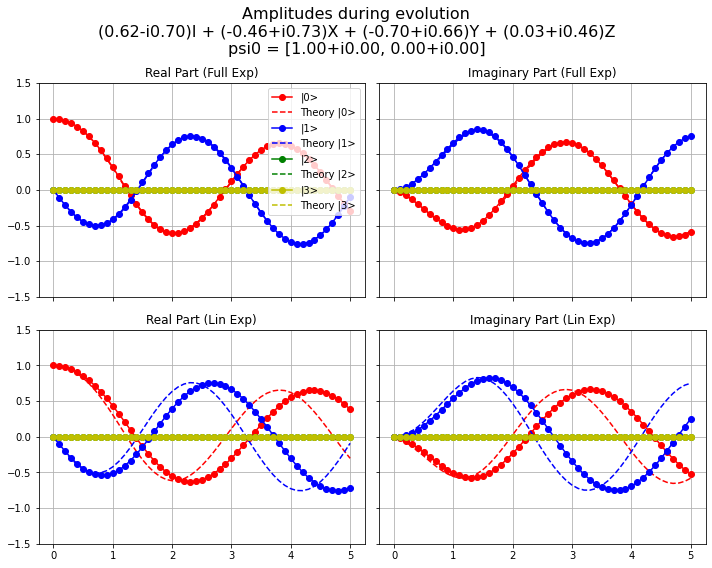

In [39]:
file_path = './figs/numerical_sims/compare_full_lin/'
psi0 = np.array([1,0,0,0], dtype=complex)
for x in range(1):
    d = 1
    l = 2
    amps = np.random.uniform(-1.0,1.0,4**l) + 1j*np.random.uniform(-1.0,1.0,4**l)
    hm_list = [
        [ [0,1,2,3], amps, [0,1] ]
    ]
    H = Hamiltonian(hm_list, d, l)
    H_mat = H.get_matrix()
    #     H.print()

    alist, slist, blist, svs_full = qite(H, psi0, N, logging=False, truncate=-1)
    alist, slist, blist, svs_lin = qite(H, psi0, N, logging=False, truncate=1)

    title = ''
    p = 'IXYZ'
    for i in range(4):
        title += '({:0.2f}{}i{:0.2f}){}'.format(np.real(amps[i]), '-' if np.imag(amps[i]) < 0 else '+', np.abs(np.imag(amps[i])), p[i] )
        if i < 3: title += ' + '
    title += '\n'
    title += 'psi0 = [{:0.2f}{}i{:0.2f}, {:0.2f}{}i{:0.2f}]'.format(
        np.real(psi0[0]), '-' if np.imag(psi0[0]) < 0 else '+', np.abs(np.imag(psi0[0])),
        np.real(psi0[1]), '-' if np.imag(psi0[1]) < 0 else '+', np.abs(np.imag(psi0[1])),
    )

    file = file_path + '{:03d}'.format(x+1)

    plot_comp(H, psi0, svs_full, svs_lin, 
              ax_titles=[ ['Real Part (Full Exp)', 'Imaginary Part (Full Exp)'], 
                           ['Real Part (Lin Exp)', 'Imaginary Part (Lin Exp)']], 
              fig_title=title, show=True, save=False, file_name=file)

In [131]:
file_path = './figs/numerical_sims/compare_full_trot/full_exp/'
for x in range(30):
    amps = np.random.uniform(-1.0,1.0,4) + 1j*np.random.uniform(-1.0,1.0,4)
    hm_list = [
        [ [0,1,2,3], amps, [0] ]
    ]
    d = 1
    l = 1
    H = Hamiltonian(hm_list, d, l)
    H_mat = H.get_matrix()
    #     H.print()

    alist, slist, blist, svs_full = qite(H, psi0, N, logging=False, truncate=-1, trotter_update=False)
    alist, slist, blist, svs_trot = qite(H, psi0, N, logging=False, truncate=1, trotter_update=True)

    title = ''
    p = 'IXYZ'
    for i in range(4):
        title += '({:0.2f}{}i{:0.2f}){}'.format(np.real(amps[i]), '-' if np.imag(amps[i]) < 0 else '+', np.abs(np.imag(amps[i])), p[i] )
        if i < 3: title += ' + '
    title += '\n'
    title += 'psi0 = [{:0.2f}{}i{:0.2f}, {:0.2f}{}i{:0.2f}]'.format(
        np.real(psi0[0]), '-' if np.imag(psi0[0]) < 0 else '+', np.abs(np.imag(psi0[0])),
        np.real(psi0[1]), '-' if np.imag(psi0[1]) < 0 else '+', np.abs(np.imag(psi0[1])),
    )

    file = file_path + '{:03d}'.format(x+1)

    plot_comp(H, psi0, svs_full, svs_trot, 
              ax_titles=[ ['Real Part (Full Exponential Full Update)', 'Imaginary Part (Full Exponential Full Update)'], 
                           ['Real Part (Full Exponential Trotterized Update)', 'Imaginary Part (Full Exponential Trotterized Update)']], 
              fig_title=title, show=False, save=True, file_name=file)

In [11]:
for x in range(1,4):
#     amps = np.random.uniform(-1.0,1.0,4) + 1j*np.random.uniform(-1.0,1.0,4)
    amps = np.zeros(4, dtype=complex)
    amps[x] = 1j
    hm_list = [
        [ [0,1,2,3], amps, [0] ]
    ]
    d = 1
    l = 1
    H = Hamiltonian(hm_list, d, l)
    H_mat = H.get_matrix()
#     H.print()

#     for truncate_exp in [-1,1]:
    file_path = './figs/numerical_sims/without 2/'
#         if truncate_exp < 0:
#             file_path += 'full_exp/'
#         elif truncate_exp == 1:
#             file_path += 'linear_exp/'

    alist, slist, blist, svs = qite(H, psi0, N, logging=False)

    title = ''
    p = 'IXYZ'
    for i in range(4):
        title += '({:0.2f}{}i{:0.2f}){}'.format(np.real(amps[i]), '-' if np.imag(amps[i]) < 0 else '+', np.abs(np.imag(amps[i])), p[i] )
        if i < 3: title += ' + '
    title += '\n'
    title += 'psi0 = [{:0.2f}{}i{:0.2f}, {:0.2f}{}i{:0.2f}]'.format(
        np.real(psi0[0]), '-' if np.imag(psi0[0]) < 0 else '+', np.abs(np.imag(psi0[0])),
        np.real(psi0[1]), '-' if np.imag(psi0[1]) < 0 else '+', np.abs(np.imag(psi0[1])),
    )

    file = file_path + 'i{}'.format(p[x])

#     plot_qite(H, psi0, svs, title, show=False, save=True, file_name=file)
    show=False
    save=True
    file_name = file
    fig_title = title
    
    f = plt.figure(figsize=(10,4))
    axs = [f.add_subplot(121), f.add_subplot(122)]
    t = np.arange(0,N+1,1)*db
    re = np.real(svs)
    im = np.imag(svs)

    theory = np.zeros( (N+1,2), dtype=complex )
    for i in range(N+1):
        v = exp_mat_psi(H.get_matrix() * i*db, psi0)
        theory[i,:] = v/np.linalg.norm(v)

    axs[0].plot(t,re[:,0],'ro-', label='|0>')
    axs[0].plot(t,re[:,1],'bo-', label='|1>')

    axs[0].plot(t, np.real(theory[:,0]), 'r--', label='theory |0>' )
    axs[0].plot(t, np.real(theory[:,1]), 'b--', label='theory |0>' )

    axs[1].plot(t,im[:,0],'ro-', label='|0>')
    axs[1].plot(t,im[:,1],'bo-', label='|1>')

    axs[1].plot(t, np.imag(theory[:,0]), 'r--', label='theory |0>' )
    axs[1].plot(t, np.imag(theory[:,1]), 'b--', label='theory |0>' )

    axs[0].set_ylim(-1.5,1.5)
    axs[1].set_ylim(-1.5,1.5)

    axs[0].title.set_text('Real Part')
    axs[1].title.set_text('Imaginary Part')
    
    if x == 1:
        axs[0].plot(t, np.cos(2*t), 'c-', label='Double Frequency |0>')
        axs[0].plot(t, np.zeros(t.shape), 'y-', label='Double Frequency |1>')
        axs[1].plot(t, np.zeros(t.shape), 'c-', label='Double Frequency |0>')
        axs[1].plot(t, np.sin(2*t), 'y-', label='Double Frequency |1>')
    elif x == 2:
        axs[0].plot(t, np.cos(2*t), 'c-', label='Double Frequency |0>')
        axs[0].plot(t, np.sin(-2*t), 'y-', label='Double Frequency |1>')
        axs[1].plot(t, np.zeros(t.shape), 'y-', label='Double Frequency |1>')
        axs[1].plot(t, np.zeros(t.shape), 'c-', label='Double Frequency |0>')
    elif x == 3:
        axs[0].plot(t, np.cos(2*t), 'c-', label='Double Frequency |0>')
        axs[1].plot(t, np.sin(2*t), 'c-', label='Double Frequency |0>')
        axs[0].plot(t, np.zeros(t.shape), 'y-', label='Double Frequency |1>')
        axs[1].plot(t, np.zeros(t.shape), 'y-', label='Double Frequency |1>')


    if x != 2:
        axs[0].legend(loc='best')
    else:
        axs[1].legend(loc='best')

    axs[0].grid()
    axs[1].grid()

    f.suptitle('Amplitudes during evolution\n'+fig_title, fontsize=16)
    f.tight_layout()
    f.set_facecolor('white')
    
    if show: plt.show()
    
    if save: f.savefig(file_name+'.png')
        
    plt.close()